In [1]:
!pip install wget torchinfo

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=12d365a19dc14416ec41fae928b9eed0c0fa4e248244180d30f85d75d707f16c
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [ ]:
!wget -O NCT-CRC-HE-100K.zip https://zenodo.org/record/1214456/files/NCT-CRC-HE-100K.zip
!unzip -qq NCT-CRC-HE-100K.zip -d train

print("dataset setup complete!")

--2025-02-24 02:13:35--  https://zenodo.org/record/1214456/files/NCT-CRC-HE-100K.zip
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.48.194, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1214456/files/NCT-CRC-HE-100K.zip [following]
--2025-02-24 02:13:36--  https://zenodo.org/records/1214456/files/NCT-CRC-HE-100K.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 11690284003 (11G) [application/octet-stream]
Saving to: ‘NCT-CRC-HE-100K.zip’

NCT-CRC-HE-100K.zip 100%[===================>]  10.89G  17.8MB/s    in 11m 22s 

2025-02-24 02:24:59 (16.3 MB/s) - ‘NCT-CRC-HE-100K.zip’ saved [11690284003/11690284003]

dataset setup complete!


In [2]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
import numpy as np
from tqdm import tqdm

import itertools
from torchinfo import summary
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
from PIL import Image

from matplotlib import pyplot as plt

import random
import torchvision.transforms.functional as TF

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

In [3]:
class ConvNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super(ConvNorm, self).__init__()
        self.linear = nn.Conv2d(
            in_channels, out_channels, kernel_size=kernel_size,
            stride=stride, padding=padding, bias=False
        )
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.linear(x)
        x = self.bn(x)
        return x

In [4]:
class Stem16(nn.Module):
    def __init__(self):
        super(Stem16, self).__init__()
        self.conv1 = ConvNorm(3, 32)
        self.act1 = nn.Hardswish()
        self.conv2 = ConvNorm(32, 64)
        self.act2 = nn.Hardswish()
        self.conv3 = ConvNorm(64, 128)
        self.act3 = nn.Hardswish()
        self.conv4 = ConvNorm(128, 256)

    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.act2(self.conv2(x))
        x = self.act3(self.conv3(x))
        x = self.conv4(x)
        return x

In [5]:
class LinearNorm(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearNorm, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias=False)
        self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x):

        if x.dim() == 3:
            B, N, C = x.shape
            x = x.reshape(B * N, C)
            x = self.bn(self.linear(x))
            x = x.reshape(B, N, -1)
        else:
            x = self.bn(self.linear(x))
        return x

In [6]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads, attn_ratio=2):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        inner_dim = head_dim * num_heads * 3
        self.qkv = LinearNorm(dim, inner_dim)

        self.proj = nn.Sequential(
            nn.Hardswish(),
            LinearNorm(dim, dim)
        )

        self.attention_biases = None
        self.attention_bias_idxs = None

    def compute_attention_bias(self, resolution):

        points = list(itertools.product(range(resolution), range(resolution)))
        N = len(points)

        attention_offsets = {}
        idxs = []

        # if N = 196, then resolution = 14
        for p1 in points:
            for p2 in points:
                offset = (abs(p1[0] - p2[0]), abs(p1[1] - p2[1]))
                if offset not in attention_offsets:
                    attention_offsets[offset] = len(attention_offsets)
                idxs.append(attention_offsets[offset])

        num_offsets = len(attention_offsets)

        # 각 attention head에 대해 num_offsets 만큼의 학습 가능한 Bias를 생성
        self.attention_biases = nn.Parameter(torch.zeros(self.num_heads, num_offsets).to(next(self.parameters()).device))
        self.attention_bias_idxs = torch.LongTensor(idxs).view(N, N).to(next(self.parameters()).device)

    def forward(self, x):
        B, N, C = x.shape
        resolution = int(N ** 0.5)

        if self.attention_biases is None or self.attention_bias_idxs.shape[0] != N:
            self.compute_attention_bias(resolution)

        qkv = self.qkv(x)
        qkv = qkv.view(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        # qkv: (3, B, num_heads, N, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2] # q, k, v: (B, num_heads, N, head_dim)

        attn = (q @ k.transpose(-2, -1)) * self.scale # attn: (B, num_heads, N, N)
        attn_bias = self.attention_biases[:, self.attention_bias_idxs].unsqueeze(0) # attn_bias: (1, num_heads, N, N)
        attn = attn + attn_bias
        attn = attn.softmax(dim=-1)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj(x)

In [7]:
class LevitMlp(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(LevitMlp, self).__init__()
        self.ln1 = LinearNorm(in_features, hidden_features)
        self.act = nn.Hardswish()
        self.drop = nn.Dropout(p=0.5, inplace=False)#dropout 적용
        self.ln2 = LinearNorm(hidden_features, out_features)

    def forward(self, x):
        x = self.ln1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.ln2(x)
        return x

In [8]:
class LevitBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=2):
        super(LevitBlock, self).__init__()
        self.attn = Attention(dim, num_heads)
        self.drop_path1 = nn.Identity()
        self.mlp = LevitMlp(dim, dim * mlp_ratio, dim)
        self.drop_path2 = nn.Identity()

    def forward(self, x):
        x = x + self.drop_path1(self.attn(x))
        x = x + self.drop_path2(self.mlp(x))
        return x

In [9]:
class CNNDownsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CNNDownsample, self).__init__()
        self.out_channels = out_channels
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.act = nn.Hardswish()

    def forward(self, x):
        # print(x.shape)
        B, N, C = x.shape # (B, N, C)  N=H*W (16 * 16 = 196)
        H = int(np.sqrt(N))
        x = x.view(B, H, H, C).permute(0, 3, 1, 2)
        x = self.conv(x)
        x = self.act(x)
        x = x.permute(0, 2, 3, 1).view(B, -1, self.out_channels)
        return x

In [10]:
class LevitStage(nn.Module):
    def __init__(self, dim, out_dim, num_heads, num_blocks, downsample=True):
        super(LevitStage, self).__init__()
        self.downsample = CNNDownsample(dim, out_dim) if downsample else nn.Identity()
        self.blocks = nn.Sequential(*[LevitBlock(out_dim, num_heads) for _ in range(num_blocks)])

    def forward(self, x):
        x = self.downsample(x)
        x = self.blocks(x)
        return x

In [11]:
class ConvLevitStage(nn.Module):
    def __init__(self, in_channels, out_channels, num_blocks, kernel_size, stride, padding):
        super(ConvLevitStage, self).__init__()
        self.layers = nn.Sequential(
            *[nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size, stride, padding)
              for i in range(num_blocks)],
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.layers(x)

In [12]:
class NormLinear(nn.Module):
    def __init__(self, in_features, out_features, dropout_prob=0.5):#drop_out_0.5 적용
        super(NormLinear, self).__init__()
        self.bn = nn.BatchNorm1d(in_features)
        self.drop = nn.Dropout(p=dropout_prob, inplace=False)
        self.linear = nn.Linear(in_features, out_features, bias=True)

    def forward(self, x):
        x = self.bn(x)
        x = self.drop(x)
        x = self.linear(x)
        return x

In [13]:
class LevitDistilled(nn.Module):
    def __init__(self, num_classes=9):
        super(LevitDistilled, self).__init__()

        self.stem = Stem16()

        self.stage1 = LevitStage(dim=256, out_dim=256, num_heads=4, num_blocks=2, downsample=False) # block 수 적용
        self.stage2 = LevitStage(dim=256, out_dim=384, num_heads=6, num_blocks=2, downsample=True)

        self.conv1x1 = nn.Sequential(
            nn.Conv2d(384, 512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self.head = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)
        self.head_dist = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)

    def forward(self, x):
        x = self.stem(x)

        B, C, H, W = x.shape
        x = x.view(B, C, -1).transpose(1, 2)
        x = self.stage1(x)
        x = self.stage2(x)

        H = W = int(x.shape[1]**0.5)
        x = x.transpose(1, 2).view(B, 384, H, W)

        x = self.conv1x1(x)

        x = torch.mean(x, dim=(2, 3))
        out = self.head(x)
        out_dist = self.head_dist(x)
        return out

In [47]:
model = LevitDistilled(num_classes=9)
print(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

batch_size = 32
learning_rate = 5e-4
num_epochs = 30

LevitDistilled(
  (stem): Stem16(
    (conv1): ConvNorm(
      (linear): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act1): Hardswish()
    (conv2): ConvNorm(
      (linear): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act2): Hardswish()
    (conv3): ConvNorm(
      (linear): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act3): Hardswish()
    (conv4): ConvNorm(
      (linear): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (stage1): LevitStage(
  

In [48]:
print(summary(model, input_size=(32, 3, 224, 224)))

Layer (type:depth-idx)                                  Output Shape              Param #
LevitDistilled                                          [32, 9]                   --
├─Stem16: 1-1                                           [32, 256, 14, 14]         --
│    └─ConvNorm: 2-1                                    [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        64
│    └─Hardswish: 2-2                                   [32, 32, 112, 112]        --
│    └─ConvNorm: 2-3                                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-3                                 [32, 64, 56, 56]          18,432
│    │    └─BatchNorm2d: 3-4                            [32, 64, 56, 56]          128
│    └─Hardswish: 2-4                                   [32, 64, 56, 56]          --
│    └─ConvNorm: 2-5                                  

In [49]:
print(summary(model, input_size=(32, 3, 224, 224), verbose=2))

Layer (type:depth-idx)                                  Output Shape              Param #
LevitDistilled                                          [32, 9]                   --
├─Stem16: 1-1                                           [32, 256, 14, 14]         --
│    └─conv1.linear.weight                                                        ├─864
│    └─conv1.bn.weight                                                            ├─32
│    └─conv1.bn.bias                                                              ├─32
│    └─conv2.linear.weight                                                        ├─18,432
│    └─conv2.bn.weight                                                            ├─64
│    └─conv2.bn.bias                                                              ├─64
│    └─conv3.linear.weight                                                        ├─73,728
│    └─conv3.bn.weight                                                            ├─128
│    └─conv3.bn.bias              

In [50]:
import torch.nn.init as init

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # CUDA 연산 시 동일한 결과 보장
    torch.cuda.manual_seed_all(seed)  # 멀티-GPU 환경에서 동일한 결과 보장
    torch.backends.cudnn.deterministic = True  # CuDNN 연산을 deterministic하게 설정
    torch.backends.cudnn.benchmark = False  # 연산 속도를 희생하고 일관된 연산을 수행

def initialize_weights(m):
    if isinstance(m, nn.Conv2d):  # Conv 레이어 초기화
        init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):  # Linear 레이어 초기화
        init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):  # BatchNorm 초기화
        init.constant_(m.weight, 1)
        init.constant_(m.bias, 0)

set_seed(42)  # 랜덤 시드 고정
model.apply(initialize_weights)

LevitDistilled(
  (stem): Stem16(
    (conv1): ConvNorm(
      (linear): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act1): Hardswish()
    (conv2): ConvNorm(
      (linear): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act2): Hardswish()
    (conv3): ConvNorm(
      (linear): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act3): Hardswish()
    (conv4): ConvNorm(
      (linear): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (stage1): LevitStage(
  

In [ ]:
train_dir     = './train/NCT-CRC-HE-100K'

In [51]:
from torch.utils.data import Dataset
from glob import glob
import cv2

class Dataset(Dataset):
    def __init__(self, dir, aug=False):

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        self.aug = aug
        self.samples = [i for i in glob(os.path.join(dir, '**/*')) if os.path.isfile(i)]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        class_name = os.path.basename(self.samples[idx]).split('-')[0]
        label = {
            'ADI': 0,
            'BACK': 1,
            'DEB': 2,
            'LYM': 3,
            'MUC': 4,
            'MUS': 5,
            'NORM': 6,
            'STR': 7,
            'TUM': 8,
        }

        img = cv2.imread(self.samples[idx], -1)[:, :, ::-1]
        img = np.float32(img) / 255.0

        if self.aug:
            if random.random() < 0.5:
                img = img[::-1]

            if random.random() < 0.5:
                img = img[:, ::-1]

            if random.random() < 0.3:
                if random.random() < 0.5:
                    img += np.random.normal(
                        0.0, np.random.uniform(0.01, 0.2),
                        (img.shape[0], img.shape[1], img.shape[2])
                    )
                else:
                    x = np.random.uniform(0.02, 0.15)
                    img += np.random.uniform(
                        -x, x,
                        (img.shape[0], img.shape[1], img.shape[2])
                    )

            if random.random() < 0.9:
                img += np.random.uniform(-0.15, 0.15, (1, 1, 3))
                img *= np.random.uniform(0.85, 1.15, (1, 1, 3))

            if random.random() < 0.3:
                kX, kY = np.random.randint(0, 4, 2) * 2 + 1
                if random.random() < 0.5:
                    img = cv2.GaussianBlur(img, (kX, kY), 0)
                else:
                    img = cv2.blur(img, (kX, kY))

        img = np.uint8(np.clip(img, 0, 1) * 255.0)
        img = self.transform(Image.fromarray(img))

        return img, label[class_name]

In [ ]:
dataset = Dataset(dir=train_dir, aug=True)

In [ ]:
import json

with open("default_index_dict.json", "r") as f:
    index_dict = json.load(f)
load_train_idx = index_dict["train_idx"]
load_val_idx = index_dict["val_idx"]
load_test_idx = index_dict["test_idx"]

In [ ]:
train_data = Subset(dataset, load_train_idx)
val_data = Subset(dataset, load_val_idx)
test_data = Subset(dataset, load_test_idx)

In [ ]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f"Train set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

Train set size: 70000
Validation set size: 15000
Test set size: 15000


In [52]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lr=learning_rate, params=model.parameters())

In [53]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [54]:
def train(model, train_loader, criterion, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(tqdm(train_loader, desc="Training")):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {accuracy:.2f}%")
    train_losses.append(epoch_loss)
    train_accuracies.append(accuracy)

In [55]:
def evaluate(model, data_loader, criterion, device, epoch, phase="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(tqdm(data_loader, desc=f"{phase}")):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Save all labels and predictions for balanced accuracy
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    balanced_acc = balanced_accuracy_score(all_labels, all_predictions)

    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    val_losses.append(epoch_loss)
    val_accuracies.append(accuracy)

In [56]:
def measure_inference_time(model, data_loader, device):
    model.eval()
    times = []

    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            start_time = torch.cuda.Event(enable_timing=True)
            end_time = torch.cuda.Event(enable_timing=True)

            start_time.record()
            _ = model(inputs)  # inference 수행
            end_time.record()

            # 시간 측정
            torch.cuda.synchronize()  # CUDA에서 모든 커널이 완료될 때까지 대기
            elapsed_time = start_time.elapsed_time(end_time)  # 밀리초 단위로 반환
            times.append(elapsed_time)

    # 통계량 계산
    times_np = np.array(times)
    total_inferences = len(times_np)
    avg_time = np.mean(times_np)
    std_dev = np.std(times_np)
    max_time = np.max(times_np)
    min_time = np.min(times_np)

    # 결과 출력
    print(f"Inference Time Measurement Results:")
    print(f"Total Inferences: {total_inferences}")
    print(f"Average Time: {avg_time:.2f} ms")
    print(f"Standard Deviation: {std_dev:.2f} ms")
    print(f"Maximum Time: {max_time:.2f} ms")
    print(f"Minimum Time: {min_time:.2f} ms")

    return times

In [ ]:
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train(model, train_loader, criterion, optimizer, device, epoch)
    evaluate(model, val_loader, criterion, device, epoch, phase="Validation")


Epoch 1/30


Training: 100%|██████████| 2188/2188 [07:04<00:00,  5.15it/s]


Train Loss: 0.8917, Train Accuracy: 67.88%


Validation: 100%|██████████| 469/469 [01:22<00:00,  5.66it/s]


Validation Loss: 0.5169, Validation Accuracy: 81.79%
Balanced Accuracy: 0.8116

Epoch 2/30


Training: 100%|██████████| 2188/2188 [07:02<00:00,  5.18it/s]


Train Loss: 0.4488, Train Accuracy: 83.97%


Validation: 100%|██████████| 469/469 [01:23<00:00,  5.65it/s]


Validation Loss: 0.3839, Validation Accuracy: 86.70%
Balanced Accuracy: 0.8651

Epoch 3/30


Training: 100%|██████████| 2188/2188 [07:03<00:00,  5.17it/s]


Train Loss: 0.3283, Train Accuracy: 88.53%


Validation: 100%|██████████| 469/469 [01:23<00:00,  5.63it/s]


Validation Loss: 0.2493, Validation Accuracy: 91.28%
Balanced Accuracy: 0.9121

Epoch 4/30


Training: 100%|██████████| 2188/2188 [07:02<00:00,  5.18it/s]


Train Loss: 0.2632, Train Accuracy: 90.99%


Validation: 100%|██████████| 469/469 [01:23<00:00,  5.59it/s]


Validation Loss: 0.2370, Validation Accuracy: 91.99%
Balanced Accuracy: 0.9219

Epoch 5/30


Training: 100%|██████████| 2188/2188 [07:02<00:00,  5.18it/s]


Train Loss: 0.2210, Train Accuracy: 92.49%


Validation: 100%|██████████| 469/469 [01:22<00:00,  5.67it/s]


Validation Loss: 0.2177, Validation Accuracy: 92.69%
Balanced Accuracy: 0.9276

Epoch 6/30


Training: 100%|██████████| 2188/2188 [07:01<00:00,  5.19it/s]


Train Loss: 0.1964, Train Accuracy: 93.29%


Validation: 100%|██████████| 469/469 [01:23<00:00,  5.61it/s]


Validation Loss: 0.1932, Validation Accuracy: 93.09%
Balanced Accuracy: 0.9325

Epoch 7/30


Training: 100%|██████████| 2188/2188 [07:02<00:00,  5.17it/s]


Train Loss: 0.1750, Train Accuracy: 94.07%


Validation: 100%|██████████| 469/469 [01:23<00:00,  5.65it/s]


Validation Loss: 0.1481, Validation Accuracy: 95.22%
Balanced Accuracy: 0.9523

Epoch 8/30


Training: 100%|██████████| 2188/2188 [07:03<00:00,  5.17it/s]


Train Loss: 0.1594, Train Accuracy: 94.65%


Validation: 100%|██████████| 469/469 [01:23<00:00,  5.64it/s]


Validation Loss: 0.1499, Validation Accuracy: 95.02%
Balanced Accuracy: 0.9517

Epoch 9/30


Training: 100%|██████████| 2188/2188 [07:02<00:00,  5.18it/s]


Train Loss: 0.1444, Train Accuracy: 95.14%


Validation: 100%|██████████| 469/469 [01:23<00:00,  5.62it/s]


Validation Loss: 0.1445, Validation Accuracy: 95.27%
Balanced Accuracy: 0.9529

Epoch 10/30


Training: 100%|██████████| 2188/2188 [07:02<00:00,  5.18it/s]


Train Loss: 0.1324, Train Accuracy: 95.40%


Validation: 100%|██████████| 469/469 [01:23<00:00,  5.62it/s]


Validation Loss: 0.1338, Validation Accuracy: 95.57%
Balanced Accuracy: 0.9567

Epoch 11/30


Training: 100%|██████████| 2188/2188 [07:02<00:00,  5.18it/s]


Train Loss: 0.1215, Train Accuracy: 95.90%


Validation: 100%|██████████| 469/469 [01:23<00:00,  5.63it/s]


Validation Loss: 0.1285, Validation Accuracy: 95.81%
Balanced Accuracy: 0.9590

Epoch 12/30


Training: 100%|██████████| 2188/2188 [07:02<00:00,  5.17it/s]


Train Loss: 0.1155, Train Accuracy: 96.08%


Validation: 100%|██████████| 469/469 [01:22<00:00,  5.65it/s]


Validation Loss: 0.1304, Validation Accuracy: 95.61%
Balanced Accuracy: 0.9581

Epoch 13/30


Training: 100%|██████████| 2188/2188 [07:02<00:00,  5.18it/s]


Train Loss: 0.1056, Train Accuracy: 96.37%


Validation: 100%|██████████| 469/469 [01:22<00:00,  5.66it/s]


Validation Loss: 0.1075, Validation Accuracy: 96.55%
Balanced Accuracy: 0.9661

Epoch 14/30


Training: 100%|██████████| 2188/2188 [07:02<00:00,  5.18it/s]


Train Loss: 0.0983, Train Accuracy: 96.65%


Validation: 100%|██████████| 469/469 [01:23<00:00,  5.65it/s]


Validation Loss: 0.1211, Validation Accuracy: 96.16%
Balanced Accuracy: 0.9618

Epoch 15/30


Training: 100%|██████████| 2188/2188 [07:04<00:00,  5.16it/s]


Train Loss: 0.0945, Train Accuracy: 96.76%


Validation: 100%|██████████| 469/469 [01:23<00:00,  5.64it/s]


Validation Loss: 0.1175, Validation Accuracy: 96.15%
Balanced Accuracy: 0.9629

Epoch 16/30


Training: 100%|██████████| 2188/2188 [07:02<00:00,  5.18it/s]


Train Loss: 0.0885, Train Accuracy: 97.01%


Validation: 100%|██████████| 469/469 [01:23<00:00,  5.65it/s]


Validation Loss: 0.1323, Validation Accuracy: 95.70%
Balanced Accuracy: 0.9590

Epoch 17/30


Training: 100%|██████████| 2188/2188 [07:03<00:00,  5.16it/s]


Train Loss: 0.0826, Train Accuracy: 97.21%


Validation: 100%|██████████| 469/469 [01:23<00:00,  5.62it/s]


Validation Loss: 0.1110, Validation Accuracy: 96.31%
Balanced Accuracy: 0.9641

Epoch 18/30


Training: 100%|██████████| 2188/2188 [07:02<00:00,  5.18it/s]


Train Loss: 0.0774, Train Accuracy: 97.35%


Validation: 100%|██████████| 469/469 [01:22<00:00,  5.67it/s]


Validation Loss: 0.1028, Validation Accuracy: 96.67%
Balanced Accuracy: 0.9668

Epoch 19/30


Training: 100%|██████████| 2188/2188 [07:02<00:00,  5.18it/s]


Train Loss: 0.0752, Train Accuracy: 97.47%


Validation: 100%|██████████| 469/469 [01:23<00:00,  5.62it/s]


Validation Loss: 0.1108, Validation Accuracy: 96.44%
Balanced Accuracy: 0.9636

Epoch 20/30


Training: 100%|██████████| 2188/2188 [07:02<00:00,  5.18it/s]


Train Loss: 0.0680, Train Accuracy: 97.68%


Validation: 100%|██████████| 469/469 [01:23<00:00,  5.61it/s]


Validation Loss: 0.1028, Validation Accuracy: 96.79%
Balanced Accuracy: 0.9685

Epoch 21/30


Training: 100%|██████████| 2188/2188 [07:03<00:00,  5.16it/s]


Train Loss: 0.0674, Train Accuracy: 97.76%


Validation: 100%|██████████| 469/469 [01:23<00:00,  5.62it/s]


Validation Loss: 0.1001, Validation Accuracy: 96.77%
Balanced Accuracy: 0.9683

Epoch 22/30


Training: 100%|██████████| 2188/2188 [07:02<00:00,  5.18it/s]


Train Loss: 0.0614, Train Accuracy: 97.85%


Validation: 100%|██████████| 469/469 [01:22<00:00,  5.66it/s]


Validation Loss: 0.0975, Validation Accuracy: 96.98%
Balanced Accuracy: 0.9701

Epoch 23/30


Training: 100%|██████████| 2188/2188 [07:04<00:00,  5.15it/s]


Train Loss: 0.0589, Train Accuracy: 98.00%


Validation: 100%|██████████| 469/469 [01:23<00:00,  5.64it/s]


Validation Loss: 0.0999, Validation Accuracy: 96.99%
Balanced Accuracy: 0.9707

Epoch 24/30


Training: 100%|██████████| 2188/2188 [07:08<00:00,  5.11it/s]


Train Loss: 0.0574, Train Accuracy: 98.04%


Validation: 100%|██████████| 469/469 [01:23<00:00,  5.63it/s]


Validation Loss: 0.1134, Validation Accuracy: 96.42%
Balanced Accuracy: 0.9653

Epoch 25/30


Training: 100%|██████████| 2188/2188 [07:03<00:00,  5.17it/s]


Train Loss: 0.0549, Train Accuracy: 98.10%


Validation: 100%|██████████| 469/469 [01:22<00:00,  5.69it/s]


Validation Loss: 0.1007, Validation Accuracy: 96.99%
Balanced Accuracy: 0.9706

Epoch 26/30


Training: 100%|██████████| 2188/2188 [07:02<00:00,  5.18it/s]


Train Loss: 0.0504, Train Accuracy: 98.26%


Validation: 100%|██████████| 469/469 [01:23<00:00,  5.63it/s]


Validation Loss: 0.1014, Validation Accuracy: 96.97%
Balanced Accuracy: 0.9701

Epoch 27/30


Training: 100%|██████████| 2188/2188 [07:03<00:00,  5.16it/s]


Train Loss: 0.0502, Train Accuracy: 98.24%


Validation: 100%|██████████| 469/469 [01:24<00:00,  5.58it/s]


Validation Loss: 0.1047, Validation Accuracy: 96.84%
Balanced Accuracy: 0.9694

Epoch 28/30


Training: 100%|██████████| 2188/2188 [07:03<00:00,  5.17it/s]


Train Loss: 0.0462, Train Accuracy: 98.40%


Validation: 100%|██████████| 469/469 [01:23<00:00,  5.65it/s]


Validation Loss: 0.0946, Validation Accuracy: 97.20%
Balanced Accuracy: 0.9724

Epoch 29/30


Training: 100%|██████████| 2188/2188 [07:03<00:00,  5.17it/s]


Train Loss: 0.0446, Train Accuracy: 98.48%


Validation: 100%|██████████| 469/469 [01:23<00:00,  5.65it/s]


Validation Loss: 0.1063, Validation Accuracy: 96.86%
Balanced Accuracy: 0.9692

Epoch 30/30


Training: 100%|██████████| 2188/2188 [07:04<00:00,  5.16it/s]


Train Loss: 0.0455, Train Accuracy: 98.43%


Validation: 100%|██████████| 469/469 [01:22<00:00,  5.68it/s]

Validation Loss: 0.0976, Validation Accuracy: 96.96%
Balanced Accuracy: 0.9701


In [ ]:
print("\nFinal Test Evaluation")
evaluate(model,test_loader, criterion, device, epoch, phase="Test")


Final Test Evaluation


Test: 100%|██████████| 469/469 [01:23<00:00,  5.65it/s]

Test Loss: 0.0979, Test Accuracy: 97.13%
Balanced Accuracy: 0.9720


In [ ]:
times = measure_inference_time(model, test_loader, device)

Inference Time Measurement Results:
Total Inferences: 469
Average Time: 6.40 ms
Standard Deviation: 0.42 ms
Maximum Time: 9.87 ms
Minimum Time: 6.07 ms


In [57]:
from torch import profiler

dummy_input = torch.randn(32, 3, 224, 224).cuda()

# Profiling inference
with profiler.profile(
    activities=[
       profiler.ProfilerActivity.CPU,
        profiler.ProfilerActivity.CUDA,  # Include if using GPU
    ],
    on_trace_ready=profiler.tensorboard_trace_handler("./logs"),  # Optional logging
    record_shapes=True,
    with_stack=True
) as prof:
    with torch.no_grad():
        model(dummy_input)


# Print results
print(prof.key_averages().table(sort_by="cuda_time_total" if torch.cuda.is_available() else "cpu_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                           aten::matmul         1.95%     209.228us        21.28%       2.285ms      95.195us       0.000us         0.00%       2.528ms     105.314us            24  
                                           aten::linear         0.91%      97.273us        13.89%       1.491ms      82.837us       0.000us         0.00%       1.820ms     101.114us            18  
         

In [58]:
from sklearn.metrics import f1_score, recall_score, precision_score, roc_curve, auc
import torch
import numpy as np
from tqdm import tqdm


def score_evaluate(model, data_loader, criterion, device, phase="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"{phase}"):
            inputs, labels = inputs.to(device), labels.to(device) # move tensors to device
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    overall_f1 = f1_score(all_labels, all_preds, average="macro")
    overall_recall = recall_score(all_labels, all_preds, average="macro")
    overall_precision = precision_score(all_labels, all_preds, average="macro")

    f1_per_class = f1_score(all_labels, all_preds, average=None)
    recall_per_class = recall_score(all_labels, all_preds, average=None)
    precision_per_class = precision_score(all_labels, all_preds, average=None)
    class_labels = sorted(set(all_labels))

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")


    print(f"Overall - F1: {overall_f1:.4f}, Recall: {overall_recall:.4f}, Precision: {overall_precision:.4f}")
    print("Per-Class Metrics:")
    for i, label in enumerate(class_labels):
        print(f"Class {label} - F1: {f1_per_class[i]:.4f}, Recall: {recall_per_class[i]:.4f}, Precision: {precision_per_class[i]:.4f}")

    return overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class

In [59]:
from sklearn.preprocessing import label_binarize

def roc_auc(model, data_loader, device, num_classes):

    y = ["F1", "Precision", "Recall"]

    model.eval()
    all_labels = []
    all_scores = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="ROC AUC"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_scores.extend(outputs.cpu().numpy())

    all_labels = label_binarize(all_labels, classes=list(range(num_classes)))
    print(f"Binarized all_labels shape: {all_labels.shape}")
    print(f"All_scores shape: {np.array(all_scores).shape}")

    fpr, tpr, _ = roc_curve(all_labels.ravel(), np.array(all_scores).ravel())
    roc_auc_value = auc(fpr, tpr)

    plt.figure(figsize=(9, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_value:0.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    print(f"Overall ROC AUC: {roc_auc_value:.4f}")

    return fpr, tpr, roc_auc_value

In [41]:
!wget -O CRC-VAL-HE-7K.zip https://zenodo.org/records/1214456/files/CRC-VAL-HE-7K.zip
!unzip -qq CRC-VAL-HE-7K.zip -d val

--2025-02-24 14:56:19--  https://zenodo.org/records/1214456/files/CRC-VAL-HE-7K.zip
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.43.25, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 800276929 (763M) [application/octet-stream]
Saving to: ‘CRC-VAL-HE-7K.zip’

CRC-VAL-HE-7K.zip     5%[>                   ]  45.57M  16.8MB/s               ^C
[CRC-VAL-HE-7K.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of CRC-VAL-HE-7K.zip or
        CRC-VAL-HE-7K.zip.zip, and cannot find CRC-VAL-HE-7K.zip.ZIP, period.


In [60]:
#torch.save(model.state_dict(), "HoViT22_withAug_7Ktest.pth")
model.load_state_dict(torch.load("HoViT22_withAug_7Ktest.pth"))

<ipython-input-60-68f730c495db>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("HoViT22_withAug_7Ktest.pth"))


<All keys matched successfully>

In [61]:
test_7k_dir = './val/CRC-VAL-HE-7K'

In [62]:
import os
test7k_dataset = Dataset(dir=test_7k_dir, aug=False)
test7k_dataloader = DataLoader(test7k_dataset, batch_size=32, shuffle=False, num_workers=8, pin_memory=False, drop_last=False)

In [64]:
overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class = score_evaluate(model, test7k_dataloader, criterion, device, phase="Test")

Test: 100%|██████████| 225/225 [00:05<00:00, 43.18it/s]


Test Loss: 0.2637, Test Accuracy: 92.76%
Overall - F1: 0.9091, Recall: 0.9161, Precision: 0.9059
Per-Class Metrics:
Class 0 - F1: 0.9411, Recall: 0.8901, Precision: 0.9983
Class 1 - F1: 0.9994, Recall: 1.0000, Precision: 0.9988
Class 2 - F1: 0.9047, Recall: 0.9941, Precision: 0.8300
Class 3 - F1: 0.9890, Recall: 0.9921, Precision: 0.9859
Class 4 - F1: 0.9295, Recall: 0.9807, Precision: 0.8834
Class 5 - F1: 0.8246, Recall: 0.8497, Precision: 0.8010
Class 6 - F1: 0.9578, Recall: 0.9501, Precision: 0.9657
Class 7 - F1: 0.6886, Recall: 0.6461, Precision: 0.7371
Class 8 - F1: 0.9474, Recall: 0.9424, Precision: 0.9525


<Figure size 2000x1200 with 0 Axes>

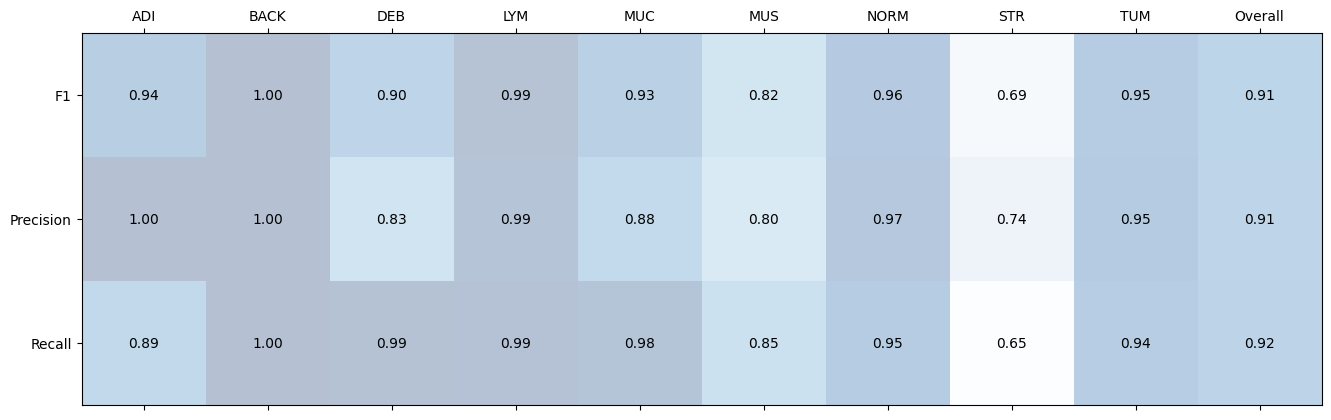

In [65]:
x = ["ADI", "BACK", "DEB", "LYM", "MUC", "MUS", "NORM", 'STR', "TUM"]
y = ["F1", "Precision", "Recall"]

f1_score_list = []
precision_score_list = []
recall_score_list = []

for i, class_name in enumerate(x):
    f1_score_list.append(f1_per_class[i])
    precision_score_list.append(precision_per_class[i])
    recall_score_list.append(recall_per_class[i])

x.append("Overall")
f1_score_list.append(overall_f1)
precision_score_list.append(overall_precision)
recall_score_list.append(overall_recall)

score_list = [f1_score_list, precision_score_list, recall_score_list]
score_list = np.array(score_list)
plt.figure(figsize=(20, 12))
score_cm = plt.matshow(score_list, cmap=plt.cm.Blues, alpha=0.3)
plt.xticks(range(len(x)), x)
plt.yticks(range(len(y)), y)
for i in range(len(y)):
    for j in range(len(x)):
        # 행렬의 각각의 수치를 각 칸의 중앙에 넣어준다
        plt.text(x=j, y=i,
                     s="{:.2f}".format(score_list[i, j]),
                     va='center',
                     ha='center',
                     )

In [68]:
times = measure_inference_time(model, test7k_dataloader, device)

Inference Time Measurement Results:
Total Inferences: 225
Average Time: 7.82 ms
Standard Deviation: 1.17 ms
Maximum Time: 13.25 ms
Minimum Time: 6.58 ms
